In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

#Import module from folder in another directory
import importlib.util
spec = importlib.util.spec_from_file_location("outliers", "data_preprocessing/outliers.py")
outliers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(outliers)

import sys
sys.path.append('data_preprocessing')
import data_preprocessing.summary as summary
import data_preprocessing.normalize as normalize

import warnings
warnings.filterwarnings("ignore")

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

%matplotlib inline

rng = np.random.RandomState(31337)

In [47]:
train_data = pd.read_csv('../data/input/ames_train.csv')
test_data = pd.read_csv('../data/input/ames_test.csv')

geo_train_data = pd.read_csv('../data/input/ames_geodemo_train.csv')
geo_test_data = pd.read_csv('../data/input/ames_geodemo_train.csv')

# Modelling without geo/census data

In [48]:
train_data = normalize.fill_in_missing_values(train_data)
train_data = outliers.remove_outliers(train_data)
#train_data = normalize.normalize(train_data)

test_data = normalize.fill_in_missing_values(test_data)
test_data = outliers.remove_outliers(test_data)
#test_data = normalize.normalize(test_data)

In [49]:
train_data = train_data.select_dtypes(include=[np.number])
test_data = test_data.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(train_data.loc[:, train_data.columns != 'SalePrice'], 
                                                  train_data['SalePrice'],
                                                  test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Random Forest

In [50]:
clf = RandomForestRegressor(n_estimators=500)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

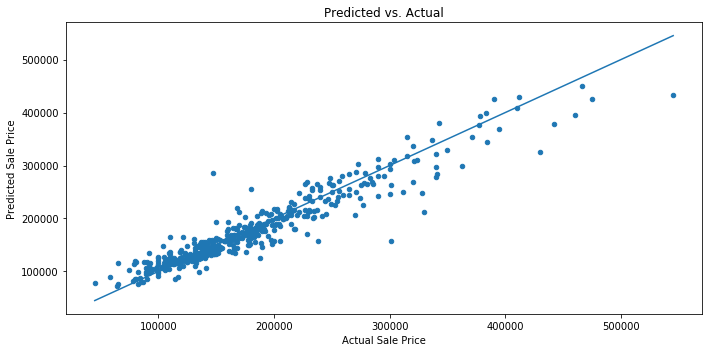

In [51]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [52]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.896791989132
Mean squared error:  24253.163542362803


## XGBoost with 5 folds

In [58]:
score = 0.0
margin = 0.0
kf = KFold(n_splits=10,shuffle=True,random_state=rng)
for train_index,test_index in kf.split(X_train):
    clf = xgb.XGBRegressor().fit(X_train[train_index],y_train[train_index])
    y_pred = clf.predict(X_train[test_index])
    actual = y_train[test_index]
    print("r2 score: ",r2_score(actual,y_pred))
    score += r2_score(actual,y_pred)
    print("Mean squared error: ", math.sqrt(mean_squared_error(actual,y_pred)))
    margin += np.median(np.abs((y_pred - actual) / actual))

print("average r2 score", score/10.0)
print('Median margin of error:', margin/10.0 )

r2 score:  0.946567137326
Mean squared error:  18853.905038665976
r2 score:  0.910144120637
Mean squared error:  22108.645304112568
r2 score:  0.880978174953
Mean squared error:  26331.937342188867
r2 score:  0.93236282424
Mean squared error:  19127.441367359752
r2 score:  0.901327531784
Mean squared error:  21315.454384445587
r2 score:  0.897418496517
Mean squared error:  23305.760565292014
r2 score:  0.904210063453
Mean squared error:  25601.673100245127
r2 score:  0.910882307748
Mean squared error:  23205.08199749237
r2 score:  0.90799576261
Mean squared error:  21988.975416461406
r2 score:  0.92885147684
Mean squared error:  19001.92265231037
average r2 score 0.912073789611
Median margin of error: 0.0605403835721


## Simple XGBoost

In [54]:
clf = xgb.XGBRegressor()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

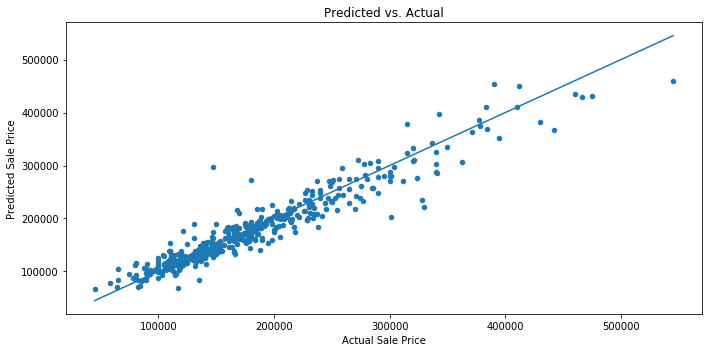

In [55]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [56]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))
print('Median margin of error:', np.median(np.abs((y_pred - y_test) / y_test)))

r2 score:  0.911397226872
Mean squared error:  22471.670008582107
Median margin of error: 0.0650079561558


## GridSearchCV With xgboost parameter optimisation

In [60]:
xgb_clf = xgb.XGBRegressor()
gridSearchClf = GridSearchCV(xgb_clf, {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
gridSearchClf.fit(X_train,y_train)
y_pred = gridSearchClf.predict(X_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    6.8s finished


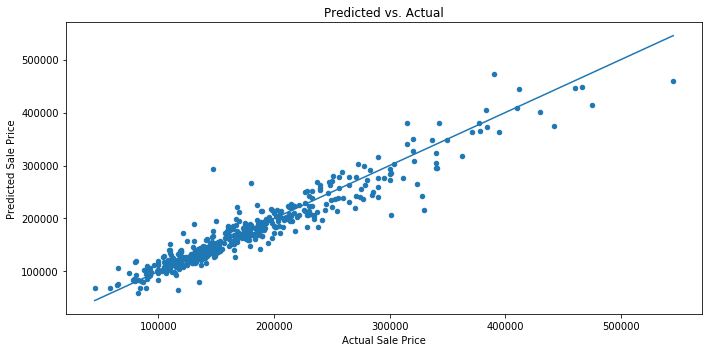

In [61]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [62]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))
print('Median margin of error:', np.median(np.abs((y_pred - y_test) / y_test)))

r2 score:  0.911750236796
Mean squared error:  22426.859674883774
Median margin of error: 0.0611893122685


## Decision Tree Regression and Adaboosting Regression

In [94]:
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

In [95]:
regr_1.fit(X_train,y_train)
y_pred = regr_1.predict(X_test)

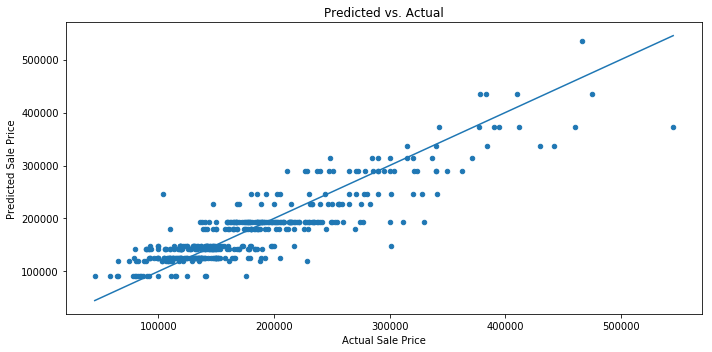

In [96]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [97]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.775020476704
Mean squared error:  35808.25745976077


In [98]:
regr_2.fit(X_train,y_train)
y_pred = regr_2.predict(X_test)

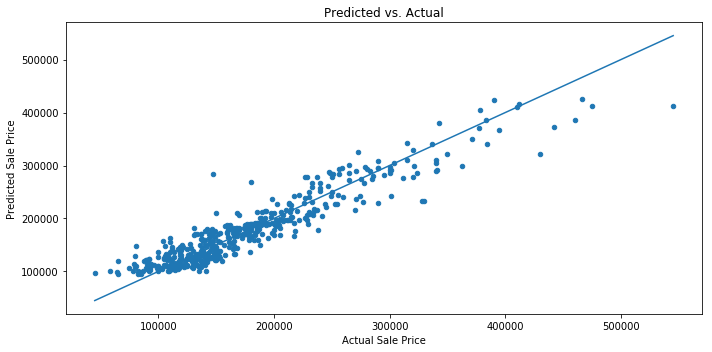

In [99]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [100]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.880865912179
Mean squared error:  26057.318010358926


# Modelling with geo/census data 

In [66]:
geo_train_data = normalize.fill_in_missing_values(geo_train_data)
geo_train_data = outliers.remove_outliers(train_data)
#train_data = normalize.normalize(train_data)

geo_test_data = normalize.fill_in_missing_values(test_data)
geo_test_data = outliers.remove_outliers(test_data)
#test_data = normalize.normalize(test_data)

In [67]:
geo_train_data = geo_train_data.select_dtypes(include=[np.number])
geo_test_data = geo_test_data.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(geo_train_data.loc[:, geo_train_data.columns != 'SalePrice'], 
                                                  geo_train_data['SalePrice'],
                                                  test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Random Forest 

In [68]:
clf = RandomForestRegressor(n_estimators=500)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

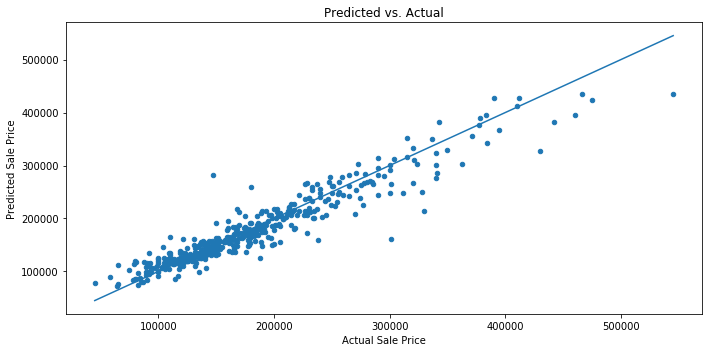

In [69]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [70]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.899114735769
Mean squared error:  23978.695858348157


## XGBoost with 5 fold

In [82]:
score = 0.0
margin = 0.0
kf = KFold(n_splits=10,shuffle=True,random_state=rng)
for train_index,test_index in kf.split(X_train):
    clf = xgb.XGBRegressor().fit(X_train[train_index],y_train[train_index])
    y_pred = clf.predict(X_train[test_index])
    actual = y_train[test_index]
    print("r2 score: ",r2_score(actual,y_pred))
    score += r2_score(actual,y_pred)
    print("Mean squared error: ", math.sqrt(mean_squared_error(actual,y_pred)))
    margin += np.median(np.abs((y_pred - actual) / actual))

print("average r2 score", score/10.0)
print('Median margin of error:', margin/10.0 )

r2 score:  0.936297842234
Mean squared error:  20075.28892321923
r2 score:  0.933109869949
Mean squared error:  20786.319345404234
r2 score:  0.90291277847
Mean squared error:  22970.412253144932
r2 score:  0.900591890761
Mean squared error:  23415.02512794487
r2 score:  0.927619642233
Mean squared error:  17957.577200585587
r2 score:  0.924224578756
Mean squared error:  18584.172135982157
r2 score:  0.889356819347
Mean squared error:  25942.010321197784
r2 score:  0.923116145021
Mean squared error:  21745.128263980376
r2 score:  0.906673345018
Mean squared error:  25316.15721028305
r2 score:  0.878859826231
Mean squared error:  23398.52880187774
average r2 score 0.912276273802
Median margin of error: 0.0602904291205


In [72]:
clf = xgb.XGBRegressor()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

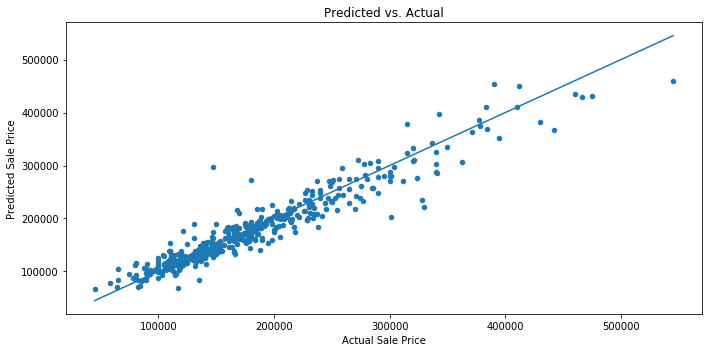

In [73]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [74]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.911397226872
Mean squared error:  22471.670008582107


## Decision tree and Adaboosting

In [75]:
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

In [76]:
regr_1.fit(X_train,y_train)
y_pred = regr_1.predict(X_test)

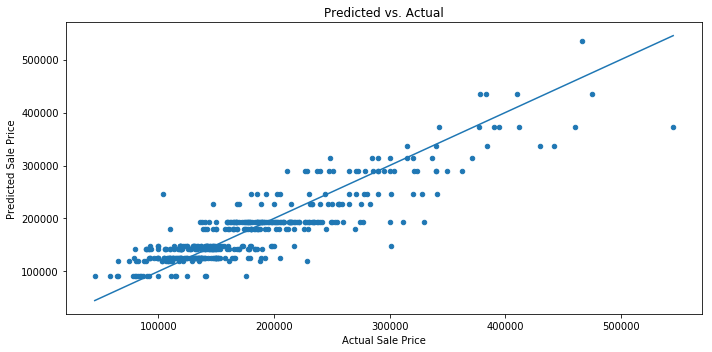

In [77]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [78]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.775020476704
Mean squared error:  35808.25745976077


In [79]:
regr_2.fit(X_train,y_train)
y_pred = regr_2.predict(X_test)

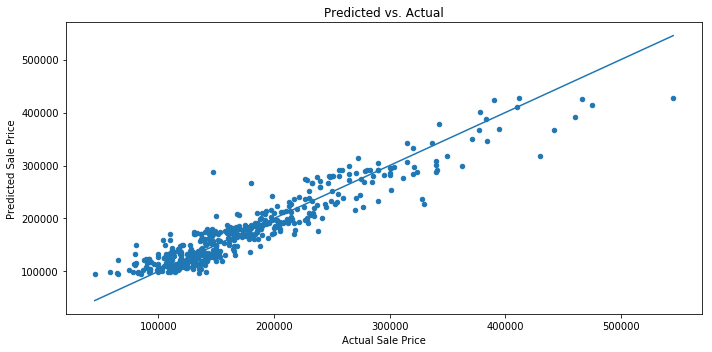

In [80]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

In [81]:
print("r2 score: ",r2_score(y_test,y_pred))
print("Mean squared error: ", math.sqrt(mean_squared_error(y_test,y_pred)))

r2 score:  0.882720859499
Mean squared error:  25853.662704648657
